# Initialization

In [1]:
import pandas as pd
import numpy as np
import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.4.0


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120

# Font
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)

# Style
plt.style.use(['science', 'grid'])

# Defining Reaction Mechanisms

## Mechanism I - The San Diego Mechanism

In [3]:
san_diego_gas = ct.Solution('sandiego2016_plus_N_CK.cti')
print('Number of species:', san_diego_gas.n_species)
print('Number of reactions:', san_diego_gas.n_reactions)



**** WARNING ****
For species C2H4OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.4211
	Value computed using high-temperature polynomial: 18.7409


**** WARNING ****
For species C2H4OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.778
	Value computed using high-temperature polynomial: 14.7264


**** WARNING ****
For species OC2H3OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.7616
	Value computed using high-temperature polynomial: 19.0815


**** WARNING ****
For species OC2H3OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -18.695
	Value computed using high-temperature polynomial: -18.741


**** WARNING ****
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.1078
	Value computed using high-tempe

## Mechanism II - Marinov + Mevel

In [4]:
marinov_species = ct.Species.listFromFile('marinov_ethanol_mechanism.cti')
marinov_reactions = ct.Reaction.listFromFile('marinov_ethanol_mechanism.cti')

mevel_species = ct.Species.listFromFile('mevel_ethanol_mechanism.cti')
mevel_reactions = ct.Reaction.listFromFile('mevel_ethanol_mechanism.cti')

new_species = []
new_reactions = []

# Filter species
for specie in mevel_species:
    # Include all nitrogen compounds except for N2
    if 'N' in specie.composition and specie.composition != {'N':2}: new_species.append(specie)

new_species_names = {specie.name for specie in new_species}
# print('N based species: {0}'.format(', '.join(name for name in new_species_names)))

marinov_mevel_species = marinov_species + new_species
marinov_mevel_species_names = {specie.name.upper() for specie in marinov_mevel_species}

# Filter reactions, keeping only those that only involve the selected species
# print('\nReactions:')
for R in mevel_reactions:
    if any(reactant in new_species_names for reactant in R.reactants) or any(product in new_species_names for product in R.products):
        # for reactant in R.reactants:
            # if reactant not in marinov_mevel_species_names:
                # print('Missing reactant:', reactant, 'when analyzing reaction', R.equation)
        # for product in R.products:
            # if product not in marinov_mevel_species_names:
                # print('Missing product:', product, 'when analyzing reaction', R.equation)
        if all(reactant in marinov_mevel_species_names for reactant in R.reactants):
            if all(product in marinov_mevel_species_names for product in R.products):
                new_reactions.append(R)
                # print('Accepted reaction:', R.equation)
# print('\n')

marinov_mevel_species = marinov_species + new_species
marinov_mevel_reactions = marinov_reactions + new_reactions

marinov_mevel_gas = ct.Solution(
    thermo='IdealGas',
    kinetics='GasKinetics',
    species=marinov_mevel_species,
    reactions=marinov_mevel_reactions
)

print('Number of species:', marinov_mevel_gas.n_species)
print('Number of reactions:', marinov_mevel_gas.n_reactions)

Number of species: 93
Number of reactions: 664


## Mechanism III - Marinov + GRI 3.0

In [5]:
marinov_species = ct.Species.listFromFile('marinov_ethanol_mechanism.cti')
marinov_reactions = ct.Reaction.listFromFile('marinov_ethanol_mechanism.cti')

gri_species = ct.Species.listFromFile('gri30.xml')
n_species = []
gri_reactions = ct.Reaction.listFromFile('gri30.xml')
n_reactions = []

# Filter species
for S in gri_species:
    comp = S.composition
    if 'N' in comp and comp != {'N':2}:
        # Include all nitrogen compounds except for N2
        n_species.append(S)
    if 'C' == S.name:
        # Include all nitrogen compounds except for N2
        n_species.append(S)

n_species_names = {S.name for S in n_species}
# print('N based species: {0}'.format(', '.join(S.name for S in n_species)))

marinov_gri_species = marinov_species + n_species
marinov_gri_species_names = {S.name.upper() for S in marinov_gri_species}


# Filter reactions, keeping only those that only involve the selected species
# print('\nReactions:')
for R in gri_reactions:
    if any(reactant in n_species_names for reactant in R.reactants) or any(product in n_species_names for product in R.products):
        # for reactant in R.reactants:
            # if reactant not in marinov_gri_species_names:
                # print('Missing reactant:', reactant, 'when analyzing reaction', R.equation)
        # for product in R.products:
            # if product not in marinov_gri_species_names:
                # print('Missing product:', product, 'when analyzing reaction', R.equation)
        if all(reactant in marinov_gri_species_names for reactant in R.reactants):
            if all(product in marinov_gri_species_names for product in R.products):
                n_reactions.append(R)
                # print('Accepted reaction:', R.equation)
# print('\n')

marinov_gri_species = marinov_species + n_species
marinov_gri_reactions = marinov_reactions + n_reactions

marinov_gri_gas = ct.Solution(
    thermo='IdealGas',
    kinetics='GasKinetics',
    species=marinov_gri_species,
    reactions=marinov_gri_reactions
)

print('Number of species:', marinov_gri_gas.n_species)
print('Number of reactions:', marinov_gri_gas.n_reactions)

Number of species: 75
Number of reactions: 494


# Comparing Ignition Delay

In [6]:
def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

## Defining IdealGasConstPressureReactor

In [7]:
# Define the reactor temperature and pressure
reactorTemperature = 1500 #Kelvin
reactorPressure = 35e5 #Pascals

gas_dict = {
    'San Diego': san_diego_gas,
    'Marinov + Mevel': marinov_mevel_gas,
    'Marinov + GRI': marinov_gri_gas,
}

result_dict = {
    'San Diego': None,
    'Marinov + Mevel': None,
    'Marinov + GRI': None,
}

for mechanism_name, gas in gas_dict.items():
    # Set temp and pressure
    gas.TP = reactorTemperature, reactorPressure
    
    # Define the fuel, oxidizer and set the stoichiometry
    try: gas.set_equivalence_ratio(phi=1, fuel='C2H5OH', oxidizer='N2O')
    except: gas.set_equivalence_ratio(phi=1, fuel='c2h5oh', oxidizer='N2O')
    
    # Create IdealGasConstPressureReactor
    reactor = ct.IdealGasReactor(contents=gas, name='Constant Pressure Reactor')
    reactorNetwork = ct.ReactorNet([reactor])

    # Compile a list of all variables for which we will store data
    stateVariableNames = [reactor.component_name(item) for item in range(reactor.n_vars)]

    # Use the above list to create a DataFrame
    timeHistory = pd.DataFrame(columns=stateVariableNames)

    # If you do not get an ignition within this time, increase it
    estimatedIgnitionDelayTime = 0.1
    t = 0
    counter = 1;
    while t < estimatedIgnitionDelayTime:
        t = reactorNetwork.step()
        timeHistory.loc[t] = reactorNetwork.get_state()
        counter += 1

    try: tau = ignitionDelay(timeHistory, 'CO')
    except: tau = ignitionDelay(timeHistory, 'co')
        
    result_dict[mechanism_name] = timeHistory

    print(mechanism_name, ' | Computed Ignition Delay: {:.3e} seconds.'.format(tau))

San Diego  | Computed Ignition Delay: 9.168e-06 seconds.
Marinov + Mevel  | Computed Ignition Delay: 4.597e-06 seconds.
Marinov + GRI  | Computed Ignition Delay: 6.450e-06 seconds.


## Plots

[]

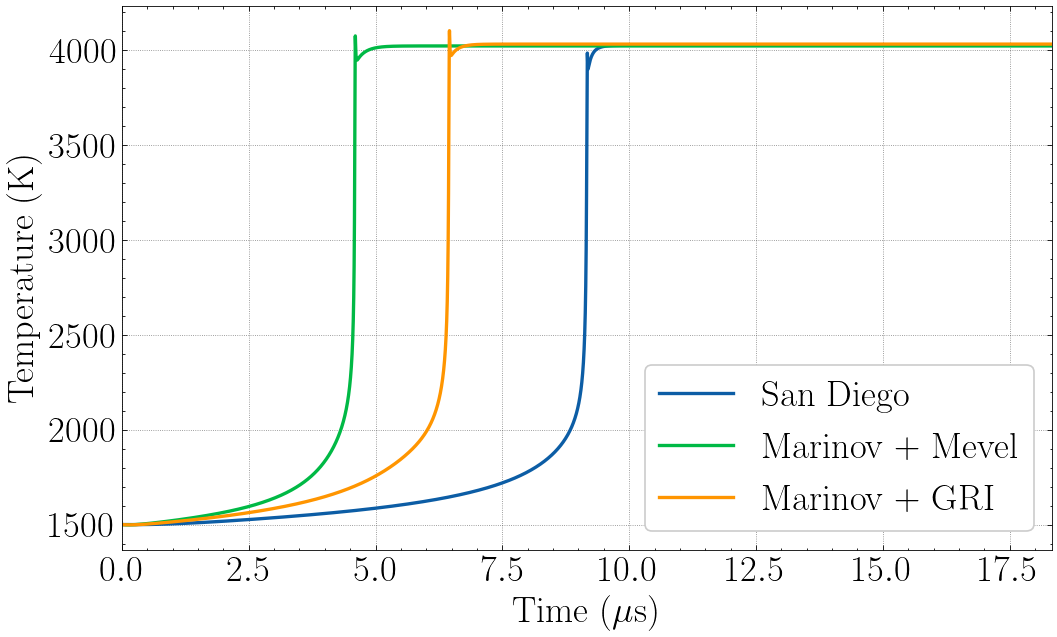

In [9]:
plt.figure(figsize=(10,6))
tau = 0.0

for mechanism_name, timeHistory in result_dict.items():
    try: tau = max(tau, ignitionDelay(timeHistory, 'CO'))
    except: tau = max(tau, ignitionDelay(timeHistory, 'co'))
        
    # try: plt.plot(timeHistory.index, timeHistory['c2h5oh'],'-o', label=mechanism_name + ' - C2H5OH')
    # except: plt.plot(timeHistory.index, timeHistory['C2H5OH'],'-o', label=mechanism_name + ' - C2H5OH')
    # plt.plot(timeHistory.index, timeHistory['N2O'],'-o', label=mechanism_name + ' - N2O')

    plt.plot(1e6*timeHistory.index, timeHistory['temperature'], label=mechanism_name, linewidth=2)
    plt.xlabel(r'Time $(\mathrm{\mu s})$')
    plt.ylabel('Temperature (K)')

plt.xlim([0,2*1e6*tau])
plt.legend()
plt.savefig('ignition_delay.pdf')
plt.plot()